# PCA: Principal Component Analysis

## Case A: Standardizing everything 

We standardize everything, including 0/1 variables. It corresponds roughly to doing PCA on a correlation matrix (each variable gets comparable scale).

Scaling 0/1 variables to unit variance can make them very influential, especially if the feature is rare (very imbalanced 0/1) or if there exists several correlated binaries (rt_* and pg_* encode similar info).

It answers the question: “what variables matter equally?”.

We will see that it is precisely why PC1 top loadings are dominated by: rt_Entire home/apt, pg_entire_unit, rt_Private room and pg_private_room. PC1 is “listing type” (entire unit vs private room) and it might be the main axis of variation in the features.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

#configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print(" libraries imported")

#loading data

#code
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"dataset not found: {data_path}")
df = pd.read_csv(data_path, compression='gzip')

print(f" dataset loaded: {df.shape}")
print(f"\n columns overview:")
print(df.columns.tolist())

#check target
if 'target_class' in df.columns:
    print(f"\n target found: {df['target_class'].nunique()} classes")
    print(df['target_class'].value_counts().sort_index())
else:
    print(" warning: 'target_class' not found in dataset")

#overview
print(f"\n first 5 rows:")
print(df.head())

#prepare X/y and train/test split

#code
print("=" * 60)
print("preparation: X/y split and train/test split")
print("=" * 60)

#split X (features) and y (target)
y = df['target_class']
X = df.drop(columns=['target_class', 'price_clean', 'city_label'])

#remove city_label if present
if 'city_label' in X.columns:
    X = X.drop(columns=['city_label'])

print(f"\nfeatures (X): {X.shape[1]} columns")
print(f"target (y): {len(y)} values")
print(f"\ndistribution of classes:")
print(y.value_counts().sort_index())

#stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"\n split done:")
print(f"  train: {X_train.shape}")
print(f"  test : {X_test.shape}")
print(f"\ndistribution train:")
print(y_train.value_counts().sort_index())
print(f"\ndistribution test:")
print(y_test.value_counts().sort_index())


 libraries imported
 dataset loaded: (73111, 30)

 columns overview:
['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']

 target found: 4 classes
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64

 first 5 rows:
   accommodates  bedrooms  beds  minimum_nights_avg_ntm  number_of_reviews  \
0             2       1.0   0.0                     2.0                  4   
1             1       1.0   1.0                    30.0                 42   
2             2       0.0   1.0                     1.0        


method 1: pca (principal component analysis)

PCA results
components for 90% variance: 18/27
components for 95% variance: 20/27
possible reduction: 25.9%


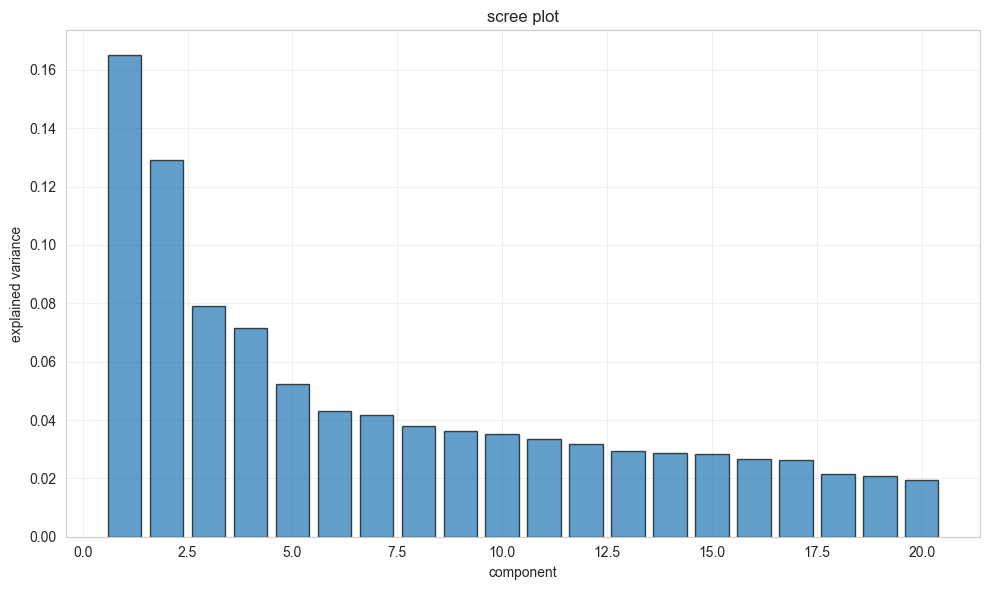

In [2]:
print("\n" + "=" * 60)
print("method 1: pca (principal component analysis)")
print("=" * 60)

#standardization
scaler_pca = StandardScaler()
X_train_std = scaler_pca.fit_transform(X_train)
X_test_std = scaler_pca.transform(X_test)

#pca
pca_full = PCA()
pca_full.fit(X_train_std)

#explained variance
var_exp = pca_full.explained_variance_ratio_
var_cum = np.cumsum(var_exp)

#number of components
n_comp_95 = np.argmax(var_cum >= 0.95) + 1
n_comp_90 = np.argmax(var_cum >= 0.90) + 1

print(f"\nPCA results")
print(f"components for 90% variance: {n_comp_90}/{X.shape[1]}")
print(f"components for 95% variance: {n_comp_95}/{X.shape[1]}")
print(f"possible reduction: {(1 - n_comp_95/X.shape[1])*100:.1f}%")

#screeplot
plt.figure(figsize=(10, 6))
plt.bar(range(1, min(21, len(var_exp)+1)), var_exp[:20], alpha=0.7, edgecolor='black')
plt.title("scree plot")
plt.xlabel("component")
plt.ylabel("explained variance")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

This scree plot displays the explained variance for the first 20 components of the PCA performed on the standardized Paris dataset. The first two components are the most significant, accounting for approximately 16.5% and 13% of the variance respectively, suggesting that the primary differences between Paris listings are captured in these initial dimensions. The elbow appears between component 3 and 5, indicating that while the dataset has many features, the most substantial structural information is concentrated in just a few.

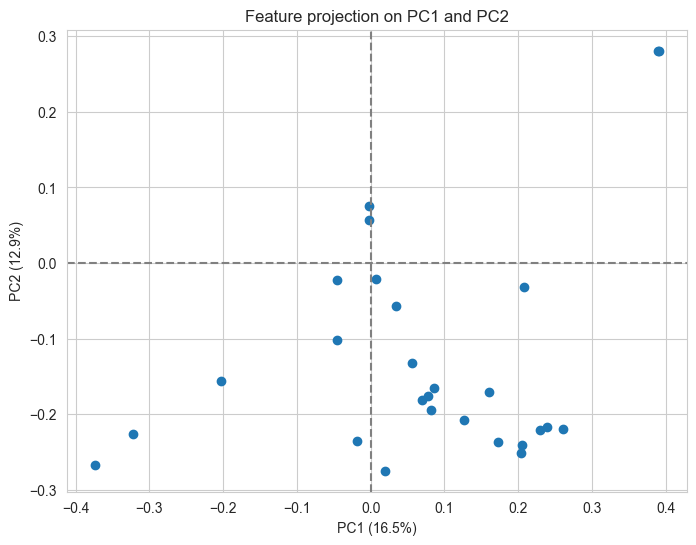

In [3]:
#plot features projection on PC1 and PC2 axes
plt.figure(figsize=(8,6))
plt.scatter(pca_full.components_[0], pca_full.components_[1])
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
pc1_pct = pca_full.explained_variance_ratio_[0]*100
pc2_pct = pca_full.explained_variance_ratio_[1]*100
plt.xlabel(f'PC1 ({pc1_pct:.1f}%)')
plt.ylabel(f'PC2 ({pc2_pct:.1f}%)')
plt.title('Feature projection on PC1 and PC2')
plt.show()

Features far to the right or left on the PC1 axis (capturing 16.5% variance) are the primary drivers of listing diversity, while those high or low on PC2 (12.9% variance) represent secondary characteristics. The isolation of certain points suggests specific attributes that act as strong differentiators, such as the outlier in the top-right quadrant which likely represents a specific listing category that scales uniquely with both components.

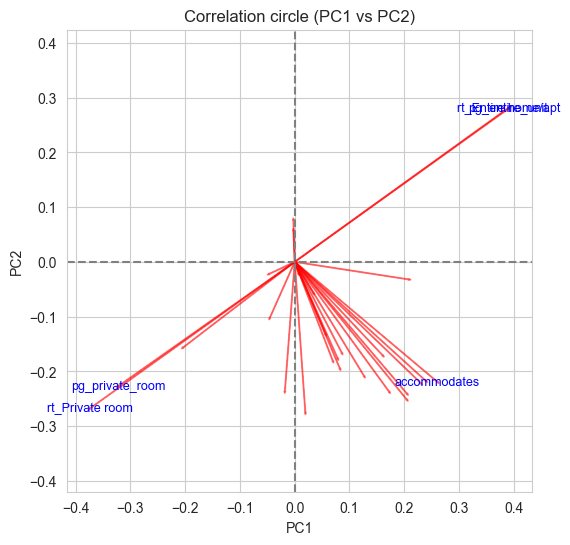

In [4]:
#correlation circle for PC1 and PC2 
plt.figure(figsize=(6,6))
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.gca().add_artist(plt.Circle((0,0), 1, color='b', fill=False))
vecs = pca_full.components_[:2]
corrs = np.linalg.norm(vecs, axis=0)
top_idx = np.argsort(corrs)[-5:] #top 5 features with highest correlation to PC1/PC2
for i in range(len(X.columns)):
    plt.arrow(0, 0, vecs[0,i], vecs[1,i], color='r', alpha=0.5)
for i in top_idx:
    plt.text(vecs[0,i], vecs[1,i], X.columns[i], fontsize=9, ha='center', va='center', color='blue')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Correlation circle (PC1 vs PC2)')
plt.axis('equal')
plt.show()

This correlation circle explicitly labels the variables driving the PCA, revealing a clear opposition in the Paris market: "rt_Entire home/apt" correlates positively with both PC1 and PC2, while "rt_Private room" and "pg_private_room" show a strong negative correlation. This indicates that the first two components effectively distinguish between renting an entire unit versus a private room. Variables like "accommodates" cluster in the lower-right, showing that listing capacity is a major factor in PC1 but moves inversely to the factors driving PC2.

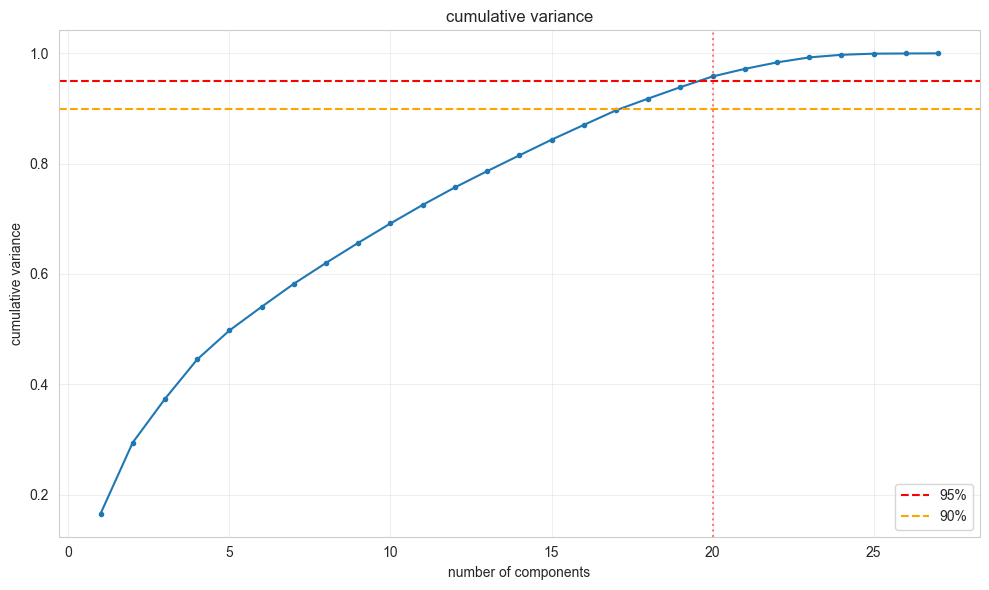

In [5]:
#cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(var_cum)+1), var_cum, marker='o', markersize=3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90%')
plt.axvline(x=n_comp_95, color='r', linestyle=':', alpha=0.5)
plt.title("cumulative variance")
plt.xlabel("number of components")
plt.ylabel("cumulative variance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The cumulative variance plot shows the "cost" of dimensionality reduction: while the first few components capture the main trends, you need 20 components to retain 95% of the original information from the paris_dataset_final_ready.csv.gz. The orange and red lines serve as benchmarks; to avoid losing significant detail about the listings, a model should likely use at least the first 20 components, as the first two components alone only account for 29.4% of the total variance.


 top 10 features PC1:
            feature  loading
 rt_Entire home/apt 0.390591
     pg_entire_unit 0.389621
    rt_Private room 0.373965
    pg_private_room 0.321908
       accommodates 0.260369
 score_chef_kitchen 0.239377
     has_dishwasher 0.230193
has_washing_machine 0.207927
               beds 0.204739
           bedrooms 0.204361


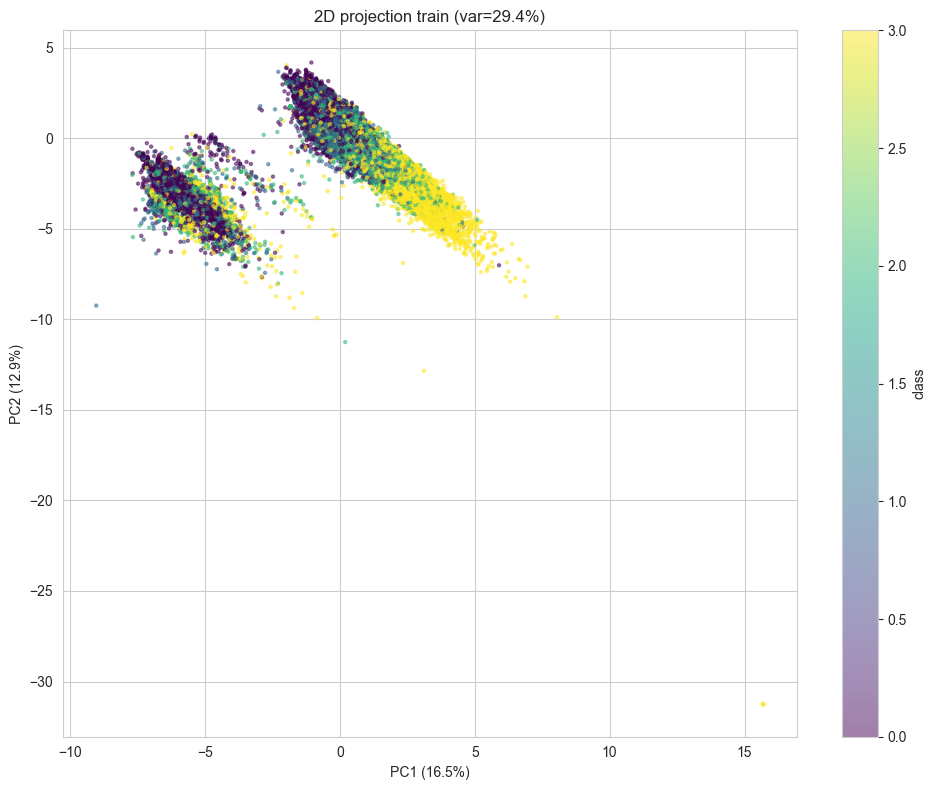

In [6]:
#2D projection
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_std)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], 
                     c=y_train, cmap='viridis', s=5, alpha=0.5)
plt.title(f"2D projection train (var={pca_2d.explained_variance_ratio_.sum():.1%})")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})")
plt.colorbar(scatter, label='class')
plt.tight_layout()

#feature importance PC1
pc1_loadings = pd.DataFrame({
    'feature': X.columns,
    'loading': np.abs(pca_full.components_[0])
}).sort_values('loading', ascending=False)

print(f"\n top 10 features PC1:")
print(pc1_loadings.head(10).to_string(index=False))

PC1 represents a "Property Scale" axis that separates the Paris market by rental type and capacity. The top features—Entire home/apt (0.39) and Private room (0.37)—along with accommodates and chef kitchen scores, drive the distinct two-cluster split seen in the 2D projection. This confirms that the listing's target_class is fundamentally determined by whether the property is a large, fully-equipped unit or a smaller shared space.

The projection maps the individual listings into PC space, color-coded by their target_class. The distinct separation into two clusters—a dense group on the left and an elongated group on the right—proves that PC1 (16.5%) is highly effective at identifying structural differences between listing types. The color gradient shows that higher-class values (yellow) are predominantly located in the right-hand cluster, suggesting that the features with high PC1 loadings (like "entire home" or "accommodates") are the strongest predictors of the listing's class.

## Case B: Separating scaling 

We should separate scaling whenever we want to see structure driven more by continuous attributes (distance, accommodates, amenities scores…) rather than “room type". 

We will use the same PCA but scaling continuous features and leave binary features as 0/1. This automatically “downweights” binaries a bit (because their variance is ≤ 0.25), and can reveal other structure.

It answers the question. : “what structure exists beyond room type?”.

X shape: (73111, 27)
y distribution:
 target_class
0    19114
2    18299
3    18249
1    17449
Name: count, dtype: int64
Detected 15 continuous columns: ['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'dist_to_center', 'bathrooms_qty', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity']
Detected 12 binary columns: ['has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room']
Prepared train shape: (58488, 27)
Prepared test shape: (14623, 27)

PCA results (scale continuous only)
components for 90% variance: 14/27
components for 95% variance: 16/27
possible reduction: 40.7%


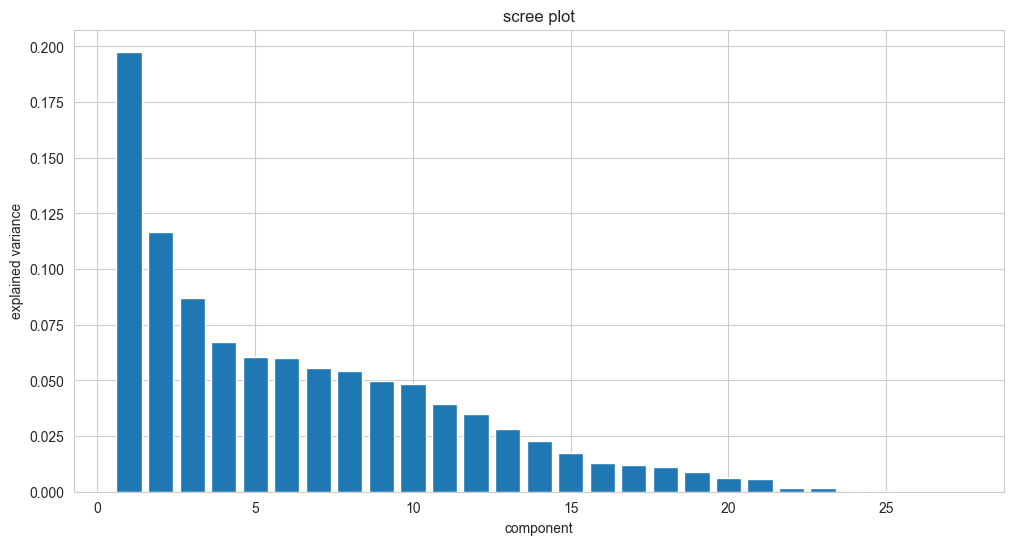

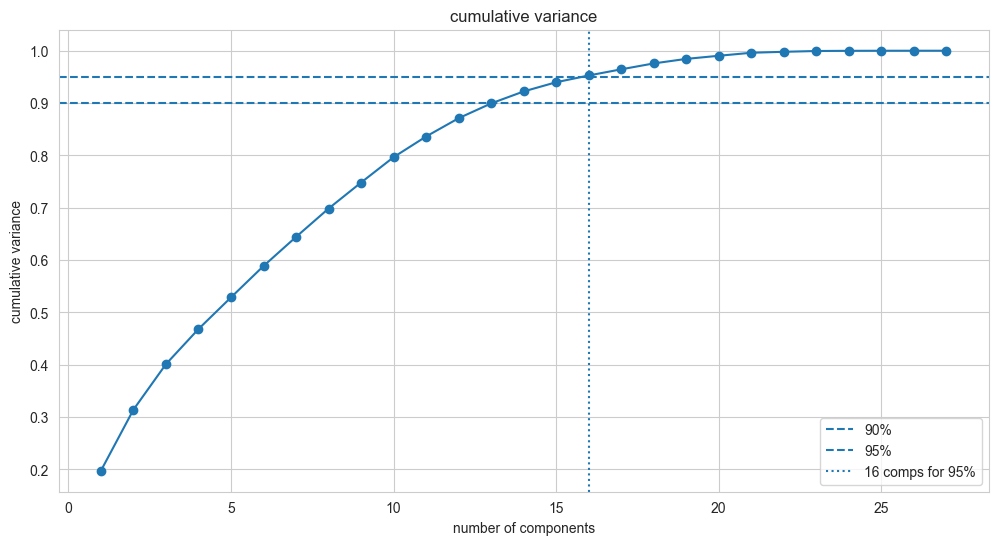

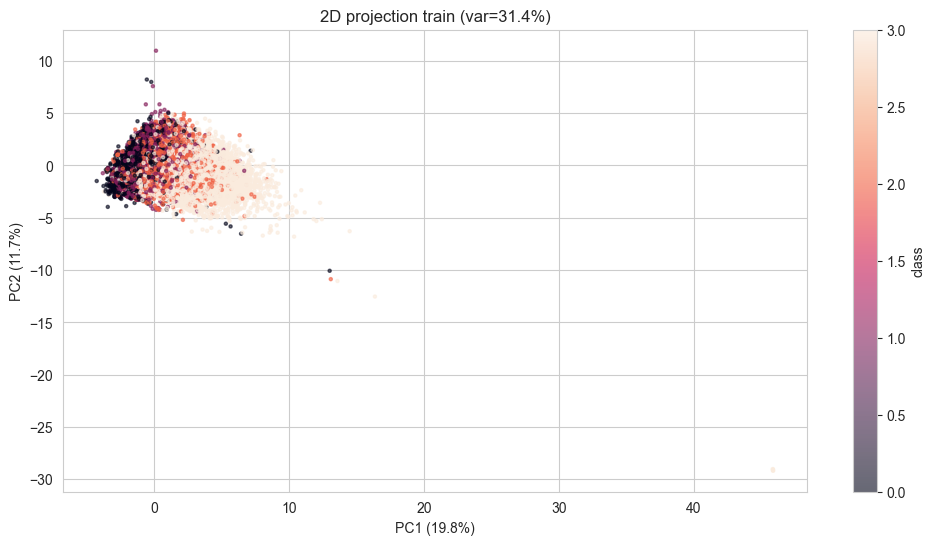


Top 10 features PC1 (abs loading):
              feature   loading
0        accommodates  0.442049
1            bedrooms  0.428658
2                beds  0.412857
3       bathrooms_qty  0.382384
4  score_chef_kitchen  0.288684
5      score_wellness  0.243695
6        score_coffee  0.211798
7          score_work  0.181516
8    standing_thermal  0.167831
9      has_dishwasher  0.135308


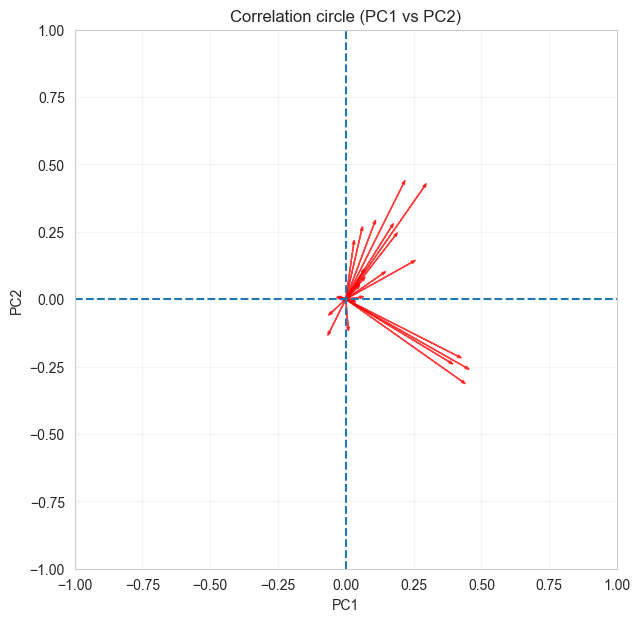

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# y = target
y = df["target_class"].copy()

# X = features (remove target and leakage-like columns)
X = df.drop(columns=["target_class", "price_clean", "city_label"], errors="ignore").copy()

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())

#  Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify binary vs continuous columns:
#    - binary: values are subset of {0,1} (or only {0} or {1})
#    - continuous: everything else
def is_binary_series(s: pd.Series) -> bool:
    vals = pd.Series(s.dropna().unique())     # Drop NA, get unique values
    if len(vals) == 0:
        return False
    try:     # Try to coerce to numeric when possible
        vals = pd.to_numeric(vals)
    except Exception:
        return False
    return set(vals.tolist()).issubset({0, 1})     # Check subset of {0,1}


binary_cols = [c for c in X_train.columns if is_binary_series(X_train[c])]
continuous_cols = [c for c in X_train.columns if c not in binary_cols]

print(f"Detected {len(continuous_cols)} continuous columns:", continuous_cols)
print(f"Detected {len(binary_cols)} binary columns:", binary_cols)

# Scale continuous features (fit on train, transform both) and Keep binary as it is.
scaler = StandardScaler()

X_train_cont_scaled = scaler.fit_transform(X_train[continuous_cols])
X_test_cont_scaled  = scaler.transform(X_test[continuous_cols])

# Convert back to DataFrame for clean concatenation
X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=continuous_cols, index=X_train.index)
X_test_cont_scaled  = pd.DataFrame(X_test_cont_scaled,  columns=continuous_cols, index=X_test.index)

# Binary stays as 0/1 (ensure numeric dtype)
X_train_bin = X_train[binary_cols].astype(float)
X_test_bin  = X_test[binary_cols].astype(float)

# Rebuild final matrices in the same column order as original X
X_train_prepared = pd.concat([X_train_cont_scaled, X_train_bin], axis=1)[X.columns]
X_test_prepared  = pd.concat([X_test_cont_scaled,  X_test_bin],  axis=1)[X.columns]

print("Prepared train shape:", X_train_prepared.shape)
print("Prepared test shape:", X_test_prepared.shape)

#PCA 
pca_full = PCA()
pca_full.fit(X_train_prepared)

explained_var = pca_full.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

n90 = np.argmax(cum_var >= 0.90) + 1
n95 = np.argmax(cum_var >= 0.95) + 1

print("\nPCA results (scale continuous only)")
print(f"components for 90% variance: {n90}/{X.shape[1]}")
print(f"components for 95% variance: {n95}/{X.shape[1]}")
print(f"possible reduction: {(1 - n95 / X.shape[1]) * 100:.1f}%")

# Scree plot
plt.figure()
plt.bar(range(1, len(explained_var) + 1), explained_var)
plt.title("scree plot")
plt.xlabel("component")
plt.ylabel("explained variance")
plt.show()

# Cumulative variance plot
plt.figure()
plt.plot(range(1, len(cum_var) + 1), cum_var, marker="o")
plt.axhline(0.90, linestyle="--", label="90%")
plt.axhline(0.95, linestyle="--", label="95%")
plt.axvline(n95, linestyle=":", label=f"{n95} comps for 95%")
plt.title("cumulative variance")
plt.xlabel("number of components")
plt.ylabel("cumulative variance")
plt.legend()
plt.show()

# 2D projection (PC1, PC2) with class color
pca_2d = PCA(n_components=2)
Z_train_2d = pca_2d.fit_transform(X_train_prepared)

plt.figure()
sc = plt.scatter(Z_train_2d[:, 0], Z_train_2d[:, 1], c=y_train, s=5, alpha=0.6)
plt.title(f"2D projection train (var={pca_2d.explained_variance_ratio_.sum()*100:.1f}%)")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)")
plt.colorbar(sc, label="class")
plt.show()

# Top 10 features for PC1
loadings_pc1 = pd.Series(pca_full.components_[0], index=X.columns)
top10_pc1 = loadings_pc1.abs().sort_values(ascending=False).head(10)

print("\nTop 10 features PC1 (abs loading):")
print(pd.DataFrame({"feature": top10_pc1.index, "loading": loadings_pc1[top10_pc1.index].values}))

# Correlation circle (PC1 vs PC2)
# Approx correlation circle: use loadings scaled by sqrt(eigenvalues) if you want true correlations,
# but your current approach of plotting components is OK for interpretation consistency.
pc1 = pca_full.components_[0]
pc2 = pca_full.components_[1]

plt.figure(figsize=(7, 7))
plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")
plt.title("Correlation circle (PC1 vs PC2)")

for i, col in enumerate(X.columns):
    plt.arrow(0, 0, pc1[i], pc2[i], head_width=0.01, alpha=0.7, color="red")
    # Option: label only the strongest arrows to keep it readable
    # if abs(pc1[i]) + abs(pc2[i]) > 0.35:
    #     plt.text(pc1[i]*1.05, pc2[i]*1.05, col, fontsize=9)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True, alpha=0.2)
plt.show()

We need fewer components: 
- 90%: 14 vs before 18
- 95%: 16 vs before 20

It is expected. 
- Before, we standardized everything: each variable contributes as 1 unit of variance. So, total variance = number of variables (27). 
- Now, continuous variables still have variance = 1 (because scaled), but binary variables keep their natural variance (≈ p(1−p), often < 0.25, sometimes much smaller if rare). Therefore, binaries contribute less to total variance, and the remaining variance is “more concentrated”, so we hit 90/95% with fewer PCs.

PCA focuses more on the continuous structure (size, distance, scores), and less on “binary noise / redundancy”.



PC1: “Size / capacity / comfort”. 
The Top 10 for PC1 is dominated by: accommodates, bedrooms, beds, bathrooms_qty. So, PC1 is bigger, more equipped and higher perceived quality.

It matches the 2D plot: the color gradient (classes) seems to move along PC1:
- low price classes concentrate more on one side
- higher classes drift toward higher PC1

Price class is strongly correlated with “size/quality” which makes sense for airbnb housing.

PC2 is probably a “secondary style/quality vs other” axis
You haven’t printed the top features of PC2, but from the plot shape, PC2 seems to slightly separate subtypes within similar PC1 (same size) — often this ends up being things like:
“scores/amenities” vs “location/distance”
or “reviews / minimum nights” effects

In [10]:
loadings_pc2 = pd.Series(pca_full.components_[1], index=X.columns)
top10_pc2 = loadings_pc2.abs().sort_values(ascending=False).head(10)
print(pd.DataFrame({"feature": top10_pc2.index, "loading": loadings_pc2[top10_pc2.index].values}))

              feature   loading
0        score_coffee  0.427640
1  score_chef_kitchen  0.416930
2            bedrooms -0.304684
3          score_view  0.280210
4    standing_thermal  0.268361
5        score_secure  0.255108
6        accommodates -0.252803
7          score_work  0.235079
8       bathrooms_qty -0.232722
9                beds -0.211101


In [9]:
rt_cols = [c for c in X.columns if c.startswith("rt_")]
pg_cols = [c for c in X.columns if c.startswith("pg_")]

corr = pd.DataFrame(index=rt_cols, columns=pg_cols)
for r in rt_cols:
    for p in pg_cols:
        corr.loc[r, p] = X[r].corr(X[p])

corr = corr.astype(float)
corr

,pg_entire_unit,pg_hotel,pg_private_room
rt_Entire home/apt,0.991545,-0.493997,-0.825274
rt_Private room,-0.927514,0.346177,0.882248
rt_Shared room,-0.156780,0.010979,-0.012236
